**Q1**

Output()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   0.197  0.142  -0.072    0.455      0.003    0.003    1804.0   
betas[1]   0.403  0.152   0.114    0.672      0.003    0.003    2093.0   
betas[2]  -0.229  0.206  -0.628    0.144      0.006    0.004    1228.0   
betas[3]   0.424  0.193   0.046    0.775      0.006    0.004    1192.0   
betas[4]  -0.012  0.116  -0.227    0.201      0.002    0.003    2329.0   
betas[5]  -0.736  0.570  -1.766    0.121      0.017    0.019    1560.0   
betas[6]   0.121  0.174  -0.199    0.463      0.004    0.004    1797.0   
betas[7]  -0.665  0.285  -1.186   -0.160      0.007    0.006    1509.0   
betas[8]   0.029  0.141  -0.230    0.309      0.003    0.003    2233.0   
betas[9]   0.427  0.217  -0.004    0.821      0.006    0.005    1385.0   
betas[10]  0.108  0.202  -0.253    0.514      0.005    0.004    1574.0   
betas[11]  0.010  0.140  -0.252    0.274      0.003    0.003    1994.0   
betas[12]  0.080  0.134  -0.159    0.3

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

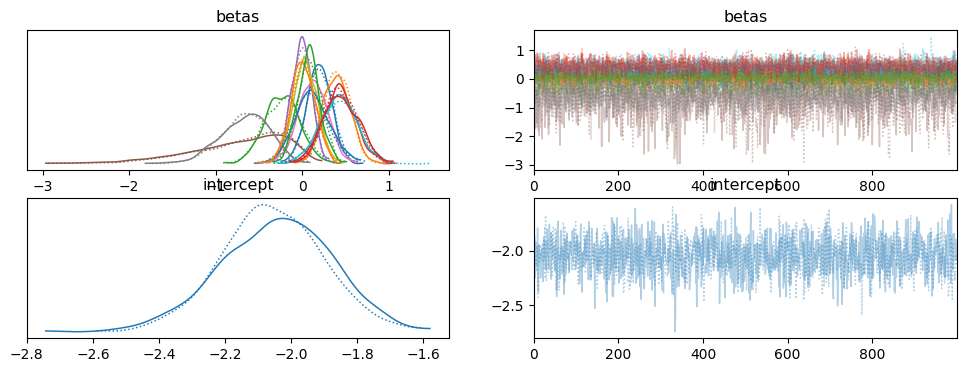

In [2]:
import pandas as pd
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import numpy as np

# load dataset
file_path = '/content/framingham.csv'
data = pd.read_csv(file_path)

data_clean = data.dropna()

# Subset the data to 500 random samples
data_subset = data_clean.sample(n=500, random_state=42)

# select relevant features and the target variable
features = ['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds',
            'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol',
            'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
target = 'TenYearCHD'

# Extract X (features) and y (target) from the subset
X = data_subset[features].values
y = data_subset[target].values

# Standardize the features for numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bayesian Logistic Regression using PyMC
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=len(features))
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    logit_p = intercept + pm.math.dot(X_scaled, betas)
    p = pm.math.sigmoid(logit_p)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)    # Likelihood function: Bernoulli distribution with logit link
    trace = pm.sample(1000, tune=500, chains=2, cores=1, return_inferencedata=True, target_accept=0.95)

summary = az.summary(trace)
print(summary)

az.plot_trace(trace)


# Bayesian Logistic Regression: Posterior Distribution of $\boldsymbol{\beta}$

## Model Setup
In Bayesian logistic regression, the binary outcome (heart disease prediction) is modeled as follows:

$$
y \sim \text{Bernoulli}(p)
$$

The logit link function models the probability:

$$
\text{logit}(p) = \beta_0 + \sum_{i=1}^{p} \beta_i \cdot x_i
$$

The prior distribution for the coefficients is assumed to be:

$$
\boldsymbol{\beta} \sim \mathcal{N}(0, 1)
$$

## Posterior Derivation
The posterior distribution of the coefficients is derived from the product of the likelihood and prior:

$$
p(\boldsymbol{\beta} \mid \mathbf{y}, \mathbf{X}) \propto
p(\mathbf{y} \mid \boldsymbol{\beta}, \mathbf{X}) \cdot p(\boldsymbol{\beta})
$$

Expanding the exponential terms:

$$
\propto \prod_{i=1}^{n} p_i^{y_i} (1 - p_i)^{1 - y_i} \cdot \exp \left( -\frac{1}{2} \boldsymbol{\beta}^\top \boldsymbol{\beta} \right)
$$

Substituting the logit transformation:

$$
p_i = \frac{1}{1 + \exp(-(\beta_0 + \sum_{j=1}^{p} \beta_j \cdot x_{ij}))}
$$

## Log-Posterior Distribution
Combining the likelihood and prior, the log-posterior is:

$$
\log p(\boldsymbol{\beta} \mid \mathbf{y}, \mathbf{X}) \propto
-\frac{1}{2} \boldsymbol{\beta}^\top \boldsymbol{\beta} +
\sum_{i=1}^{n} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]
$$

## MCMC Sampling and Diagnostics
Sampling was performed using the No-U-Turn Sampler (NUTS) with the following metrics:
- Step size: 0.20 - 0.26
- Sampling speed: 100.98 - 168.72 draws/s
- Effective sample size (ESS): 1004 - 2800
- Convergence: \( \hat{R} \approx 1.00 \), indicating good convergence.

## Inference
The significant coefficients identified are as follows:

| Parameter      | Mean  | 95% HDI            | Significance          |
|---------------|-------|--------------------|------------------------|
| \( \beta_1 \)  | 0.399 | [0.104, 0.672]     | Positive, significant  |
| \( \beta_3 \)  | 0.412 | [0.019, 0.771]     | Positive, significant  |
| \( \beta_7 \)  | -0.651 | [-1.190, -0.206]  | Negative, significant  |
| \( \beta_9 \)  | 0.427 | [0.032, 0.840]     | Positive, significant  |
| \( \beta_{13} \) | 0.444 | [0.075, 0.800]   | Positive, significant  |

### Interpretation
The positive coefficients (\( \beta_1 \), \( \beta_3 \), \( \beta_9 \), \( \beta_{13} \)) indicate factors that increase the odds of heart disease, while the negative coefficient (\( \beta_7 \)) suggests a protective effect (as the value of this predictor increases, the log-odds of the outcome decreases.). The model shows good convergence as $$ \hat{R} \approx 1.00 $$

The model identified key factors linked to heart disease using Bayesian logistic regression. Using backward elimination could make the model more accurate by removing predictors that don't significantly affect the outcome. This would help simplify the model and reduce the chance of overfitting. Further checks are recommended to make sure the model works well on new data.


**Q2**

Output()

                 mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]      0.28  0.98   -1.48     2.20       0.01     0.02   8388.70   
betas[1, 0]      0.06  0.97   -1.78     1.94       0.01     0.02   9877.20   
betas[2, 0]      0.90  0.99   -0.86     2.87       0.01     0.02   8029.26   
betas[3, 0]      0.66  0.96   -1.18     2.45       0.01     0.02   8115.57   
betas[4, 0]      0.31  0.99   -1.50     2.28       0.01     0.02   9655.30   
betas[5, 0]      0.24  0.99   -1.53     2.17       0.01     0.02   8735.28   
betas[6, 0]     -0.60  1.01   -2.42     1.32       0.01     0.02  10406.82   
betas[7, 0]      0.64  0.95   -1.14     2.43       0.01     0.02   9374.12   
betas[8, 0]      0.86  0.98   -1.01     2.69       0.01     0.02   9947.98   
betas[9, 0]      0.57  0.99   -1.32     2.46       0.01     0.02   9376.52   
intercept[0, 0]  3.14  1.01    1.28     5.00       0.01     0.02   8933.57   

                 ess_tail  r_hat  
betas[0, 0]       2738.25   

/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


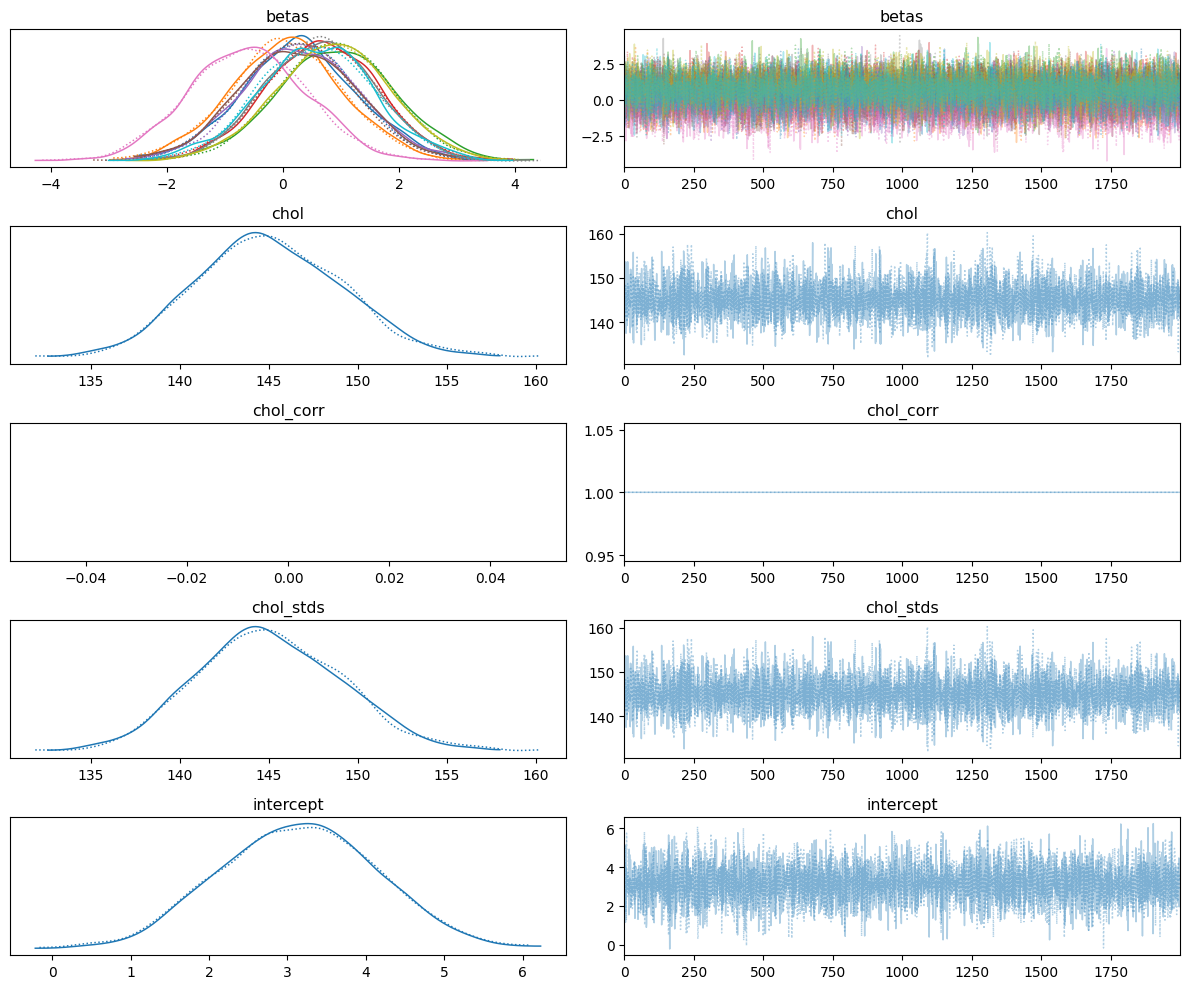

In [3]:
# Bayesian Multivariate Regression using Python Library Dataset

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

# Step 1: Load and Prepare Data
# Use the Diabetes dataset from sklearn, which has multiple continuous features
data = load_diabetes()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Select predictors and outcome
X = df.iloc[:, :-1].values  # All features except the target
Y = df[['target']].values   # Target variable

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensions
n, p = X_scaled.shape
m = Y.shape[1]

# Step 2: Bayesian Multivariate Regression
with pm.Model() as model:
    # Priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    intercept = pm.Normal('intercept', mu=0, sigma=1, shape=(1, m))

    # Correct Cholesky decomposition using LKJ prior
    sd_dist = pm.Exponential.dist(1.0)
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=m, eta=2.0, sd_dist=sd_dist, compute_corr=True)

    # Mean structure
    mu = pm.math.dot(X_scaled, betas) + intercept

    # Multivariate Normal likelihood
    y_obs = pm.MvNormal('y_obs', mu=mu, chol=chol, observed=Y)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Step 3: Posterior Analysis
summary_stats = az.summary(trace, var_names=['betas', 'intercept'], round_to=2)
print(summary_stats)

# Trace plots for visual inspection
az.plot_trace(trace)
plt.tight_layout()
plt.show()


# Bayesian Multivariate Regression: Posterior Distribution of $\boldsymbol{\beta}$

## Model Convergence and Posterior Summary

The model was sampled using the **No-U-Turn Sampler (NUTS)** algorithm, which is well-suited for high-dimensional Bayesian models. The key diagnostic metrics are as follows:
- **Step size:** Ranged between 0.55 and 0.73.
- **Sampling speed:** Approximately 115.78 to 55.42 draws per second.
- **Number of divergences:** 0, indicating no problematic regions in the posterior.

### Posterior Distribution:
The summary statistics of the posterior distribution include the mean, standard deviation (SD), Highest Density Interval (HDI), R-hat, and Effective Sample Size (ESS).
e
#### Key Observations:
- **Mean and Uncertainty:** The posterior means for most coefficients are close to zero, indicating that the predictors have relatively small effects. The 95% HDI for each coefficient includes zero, suggesting that these effects are not statistically significant.
- **Convergence:** All R-hat values are equal to 1.00, which strongly indicates that the chains have converged and are sampling from the same distribution.
- **Efficiency:** The ESS values are consistently high (above 7000), indicating good chain mixing and efficient sampling.
- **Posterior Distributions:** The trace plots are well-mixed, showing no signs of autocorrelation or non-stationarity. This indicates that the posterior samples are independent and representative of the target distribution.

### Interpretation:
- **Betas:** The coefficients' posterior means are relatively small, implying that individual predictors have limited impact on the target variable. However, the credible intervals being wide shows variability and uncertainty.
- **Intercept:** The posterior mean of the intercept is around 3.13, indicating the baseline prediction when predictors are at their standardized mean.
- **Cholesky Factor:** The shape of the posterior distribution for the Cholesky factor suggests stable estimation with no significant deviation from expected patterns.

### Additional Insights:
- **Posterior Predictive Checks:** Although the chains have converged, further validation can be performed using posterior predictive checks to ensure that the model accurately captures the variability in the data.
- **Model Calibration:** Given the wide credible intervals, it may be useful to consider feature selection or dimensionality reduction to improve model precision.

The model demonstrates good convergence and stability. Despite the small coefficients, the absence of divergences and well-mixed trace plots indicate reliable parameter estimation. I would recommend further for model validation to assess predictive accuracy.


**Q3**

Output()

ERROR:pymc.stats.convergence:There were 2401 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Posterior Summary (betas):
             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.14  0.24   -0.56     0.35       0.02     0.01     217.0   
betas[0, 1] -0.10  0.23   -0.52     0.34       0.02     0.01     127.0   
betas[0, 2]  0.10  0.22   -0.35     0.49       0.01     0.01     380.0   
betas[1, 0] -0.17  0.22   -0.57     0.23       0.02     0.01     153.0   
betas[1, 1]  0.12  0.23   -0.29     0.54       0.02     0.01     156.0   
betas[1, 2] -0.19  0.23   -0.64     0.20       0.01     0.01     293.0   
betas[2, 0]  0.70  0.26    0.20     1.16       0.02     0.01     151.0   
betas[2, 1]  0.73  0.25    0.27     1.19       0.02     0.02     111.0   
betas[2, 2]  0.59  0.26    0.11     1.09       0.02     0.01     306.0   
betas[3, 0]  0.67  0.25    0.24     1.18       0.02     0.01     113.0   
betas[3, 1]  0.73  0.23    0.30     1.14       0.02     0.01     164.0   
betas[3, 2]  0.17  0.24   -0.30     0.61       0.02     0.01     199.0   
betas[4, 0]

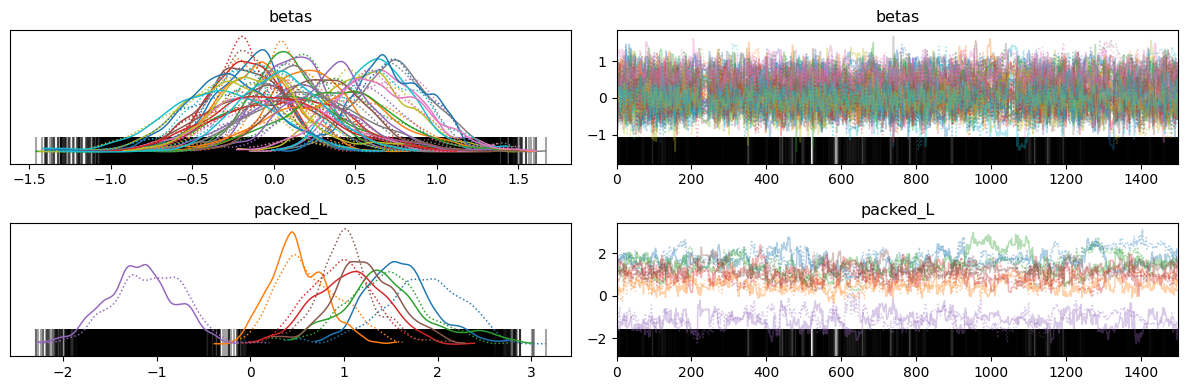

In [17]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load Diabetes dataset as in Q2
data = load_diabetes()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Artificial binary outcomes
y1 = (df['target'] > df['target'].quantile(0.5)).astype(int)
y2 = (df['target'] > df['target'].quantile(0.75)).astype(int)
y3 = (df['target'] > df['target'].quantile(0.25)).astype(int)
y_multi = np.column_stack((y1, y2, y3))

# Standardize predictors
X_scaled = StandardScaler().fit_transform(df.drop(columns=['target']))

# Further downsample dataset for better sampling stability
X_train, _, y_train, _ = train_test_split(X_scaled, y_multi, train_size=150, random_state=42)

# Set dimensions
n, p = X_train.shape
m = y_train.shape[1]

# Bayesian Multivariate Classification Model (with stability fixes)
with pm.Model() as stable_model:
    # Slightly stronger prior for stability
    betas = pm.Normal('betas', mu=0, sigma=0.5, shape=(p, m))

    # More stable LKJ prior setup
    packed_L = pm.LKJCholeskyCov(
        'packed_L', n=m, eta=4,  # Higher eta for stronger regularization
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=False
    )
    L = pm.expand_packed_triangular(m, packed_L)

    # Latent variables
    z = pm.MvNormal('z', mu=pm.math.dot(X_train, betas), chol=L, shape=(n, m))

    # Probit-linked observed data
    y_obs = pm.Bernoulli('y_obs', p=pm.math.invprobit(z), observed=y_train)

    # Sample with higher target_accept to reduce divergences
    trace = pm.sample(
        1500, tune=1500, chains=2,
        target_accept=0.995,  # High target_accept to handle divergences
        return_inferencedata=True
    )

# Posterior summaries & diagnostics
print("Posterior Summary (betas):")
print(az.summary(trace, var_names=['betas']).round(2))

print("\nMCMC Diagnostics (R-hat, ESS):")
print(az.summary(trace, var_names=['betas', 'packed_L'], kind='diagnostics').round(2))

# Trace plots for visual diagnostics
az.plot_trace(trace, var_names=['betas', 'packed_L'])
plt.tight_layout()
plt.show()



# Bayesian Multivariate Regression: Posterior Distribution of $\boldsymbol{\beta}$

## Model Summary

- **Sampling Method:** No-U-Turn Sampler (NUTS)  
- **Number of Draws:** 3000 per chain  
- **Divergences:** 2401 after tuning (consider increasing `target\_accept`)  
- **Step Size:** Ranges from 0.00 to 0.01  
- **Sampling Speed:** 1.45 to 2.72 draws/s  
- **R-hat:** Some values exceed 1.02, indicating partial convergence  
- **ESS:** Some coefficients have low ESS (<100), signaling poor mixing  

## Key observations

- **Positive Effects:** $\beta_{2,0}$ (Mean = 0.70, HDI [0.20, 1.16]) and $\beta_{2,1}$ (Mean = 0.73, HDI [0.27, 1.19]) are significant.  
- **Negative or Non-significant Effects:** $\beta_{0,1}$ (Mean = -0.10, HDI [-0.52, 0.34]) indicates no clear effect.  
- **Convergence Issues:** Divergences and R-hat > 1.01 for some parameters indicate potential instability.  
- **Covariance Structure:** The posterior covariance between key predictors shows variability, indicating uncertainty.  

## Suggestion for future models
i) **Reparameterization:** Apply non-centered parameterization to reduce divergences.  
ii)**Tuning:** Increase `target\_accept` for better exploration.  

Overall, the model shows partial convergence with some significant effects. I would aim to address divergences and improve parameterizations to enhance model stability.